In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate, optimize, special, interpolate
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV as cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

import powerlaw

In [121]:
df = pd.read_pickle("../data/df.pickle")
df.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346,"(41.8964, -87.661)","(41.9322, -87.6586)"
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629,"(41.9244, -87.7154)","(41.9306, -87.7238)"
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661,"(41.8945, -87.6179)","(41.8679, -87.623)"
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375,"(41.903, -87.6975)","(41.8992, -87.6722)"
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685,"(41.8902, -87.6262)","(41.9695, -87.6547)"


In [122]:
df_2020 = df[(df["started_at"] >= "2020-04-01") & (df["started_at"] <= "2020-12-31")]
df_2021_2023 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] <= "2023-10-31")]

In [124]:
df_2020['started_at'] = pd.to_datetime(df_2020['started_at'])
df_2020['ended_at'] = pd.to_datetime(df_2020['ended_at'])
df_2021_2023['started_at'] = pd.to_datetime(df_2021_2023['started_at'])
df_2021_2023['ended_at'] = pd.to_datetime(df_2021_2023['ended_at'])

# df_2021のdistanceを1日ごとに集計する
distance_2020 = []
current_timestamp = df_2020["started_at"].min()
end_timestamp = df_2020["started_at"].max()
interval = timedelta(days=1)

while current_timestamp <= end_timestamp:
    next_timestamp = current_timestamp + interval
    df_tmp = df_2020[(df_2020['started_at'] >= current_timestamp) & (df_2020['started_at'] < next_timestamp)]
    distance_2020.append(np.mean(df_tmp["distance"]))
    current_timestamp = next_timestamp

# df_2022_2023のdistanceを1日ごとに集計する
distance_2021_2023 = []
current_timestamp = df_2021_2023["started_at"].min()
end_timestamp = df_2021_2023["started_at"].max()
interval = timedelta(days=1)

while current_timestamp <= end_timestamp:
    next_timestamp = current_timestamp + interval
    df_tmp = df_2021_2023[(df_2021_2023['started_at'] >= current_timestamp) & (df_2021_2023['started_at'] < next_timestamp)]
    distance_2021_2023.append(np.mean(df_tmp["distance"]))
    current_timestamp = next_timestamp

In [127]:
# distance_2020のnanを補完する
distance_2020 = pd.Series(distance_2020)
distance_2020 = distance_2020.dropna()

Calculating best minimal value for power law fit
2.5072101444451933
1.6124098517773555
0.09138803861102916
0.4395936394337602


<Axes: >

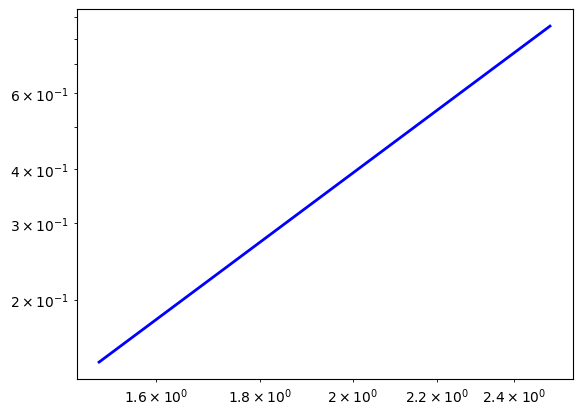

In [128]:
# distance_2020のpowerlawフィッティング
fit = powerlaw.Fit(distance_2020, discrete=True)
print(fit.power_law.alpha)
print(fit.power_law.xmin)
print(fit.power_law.sigma)
print(fit.power_law.D)

fit.plot_pdf(color='b', linewidth=2)